<a href="https://colab.research.google.com/github/ShinwooChoi/ESAA-OB/blob/main/11_21_ESAA_OB_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<딥러닝 파이토치 교과서> 5장 p.179-200

## 5.2 합성곱 신경망 맛보기

### fashion_mnist 데이터셋
- torchvision에 포함된 예제 데이터로 운동화, 셔츠, 샌들 등의 28×28 픽셀 이미지 7만개로 구성됨
- train_images: 0~255 값의 28×28 NumPy 배열
- train_labels: 0~9 정수, 이미지의 클래스(운동화, 셔츠 등)를 의미함

### GPU 사용
- PyTorch는 기본적으로 GPU 사용을 권장
- GPU가 없으면 CPU로 동작
- nn.DataParallel 사용 시 여러 GPU로 병렬 처리 가능

### torchvision.datasets 주요 파라미터
- 첫 번째 파라미터: 데이터셋 다운로드 위치
- download=True: 해당 위치에 데이터가 없으면 다운로드
- transform: 텐서 형태(0~1)로 변환

### DataLoader
- 배치 단위로 데이터를 불러오고 섞을 수 있음
- 첫 번째 파라미터: 불러올 데이터셋
- batch_size: 배치 크기

### np.random
- np.random은 무작위 데이터 생성
- randint(len(dataset)): 0~len(dataset)-1 범위의 정수 하나를 무작위 추출

### 객체 지향 개념
- PyTorch는 C++ 기반 구조 → 객체(클래스 기반) 사용
- 객체(object)는 메모리에 할당된 데이터 묶음
- 클래스(class)는 객체를 만들어내는 설계도

### 클래스와 함수
- 함수(function)는 특정 작업을 수행하는 독립적인 코드
- 클래스는 함수 + 관련 변수들을 하나로 묶어 재사용 가능하게 함

### nn.Linear 파라미터
- in_features: 입력 크기
- out_features: 출력 크기
- forward(): 입력 데이터를 받아 연산을 수행해 결과 반환

### Dropout(p)
- 텐서 값 중 p 비율만 0으로 변경
- 나머지 값들은 (1/(1-p))로 보정됨

### view() 함수
- 텐서의 shape을 변경
- view(-1, 784): (?, 784) 형태로 변경
- -1은 행(row)의 수를 자동 계산하라는 의미

### 활성화 함수 지정
- F.relu(): functional API 방식
- nn.ReLU(): 클래스 방식
- functional.xx는 가중치 직접 전달 필요 / nn.xx는 모듈 내부에 포함됨

### nn.Conv2d 기본 개념
- 합성곱 연산을 통해 이미지 특징 추출
- 커널(kernel)은 n×m 크기 행렬이며 이미지 특성을 추출
- in_channels: 입력 채널 수 (흑백=1, RGB=3)
- out_channels: 출력 채널 수
- kernel_size: 커널 크기 (예: 3×3)
- padding: 입력 주변을 0으로 채워 출력 크기를 조절

### BatchNorm2d
- 배치별로 평균/분산을 조정하여 정규화
- 출력 분포를 일정하게 유지 → 학습 안정화

### MaxPool2d
- 이미지 크기를 줄이는 역할
- kernel_size: 풀링 영역의 크기
- stride: 이동 간격 (stride가 크면 더 많이 줄어듦)

### 분류를 위한 완전연결층 변환
- Conv2d/MaxPool2d는 3차원 텐서로 출력
- 완전연결층으로 보내기 위해 view()로 1차원으로 변환

### Conv2d 출력 크기 공식
- 출력 크기 = (W − F + 2P) / S + 1
  - W: 입력 크기
  - F: 커널 크기
  - P: 패딩 크기
  - S: 스트라이드

### MaxPool2d 출력 크기
- 출력 크기 = IF / F
  - IF: 입력 필터 크기
  - F: 커널 크기

### 분류 문제의 정확도
- classification accuracy = (correct predictions / total predictions) × 100
- error rate = (1 − accuracy)

### 다중 클래스 분류 시 주의점
- 정확도가 높아도 데이터 분포가 불균형하면 의미 없을 수 있음
- 예: 전체 데이터의 90%가 하나의 클래스일 경우, 전부 그 클래스로 예측해도 90% 정확도

### Sequential 사용
- 여러 계층을 순서대로 쌓는 간단한 방법
- forward() 함수 없이도 자동으로 순차 실행 가능



In [1]:
#라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
#CPU 혹은 GPU 장치 확인
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#fashion_mnist 데이터셋 내려받기
train_dataset=torchvision.datasets.FashionMNIST('./content', download=True,
                                                transform=transforms.Compose([transforms.ToTensor()]))
test_dataset=torchvision.datasets.FashionMNIST('./content', download=True,
                                                train=False, transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 277kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.05MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.3MB/s]


In [4]:
#fashion_mnist 데이터를 데이터로더에 전달
train_loader=torch.utils.data.DataLoader(train_dataset,
                                         batch_size=100)
test_loader=torch.utils.data.DataLoader(test_dataset,
                                        batch_size=100)

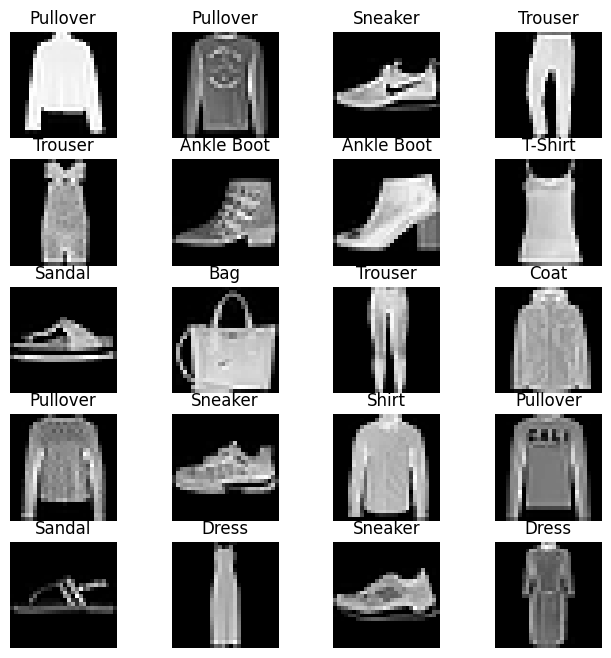

In [5]:
#분류에 사용될 클래스 정의
labels_map={0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
            5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

fig=plt.figure(figsize=(8,8))
columns=4
rows=5
for i in range(1, columns*rows+1):
    img_xy=np.random.randint(len(train_dataset))
    img=train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [6]:
#심층 신경망 모델 생성
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1=nn.Linear(in_features=784, out_features=256)
        self.drop=nn.Dropout(0.25)
        self.fc2=nn.Linear(in_features=256, out_features=128)
        self.fc3=nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):
        out=input_data.view(-1, 784)
        out=F.relu(self.fc1(out))
        out=self.drop(out)
        out=F.relu(self.fc2(out))
        out=self.fc3(out)
        return out

In [7]:
#심층 신경망에서 필요한 파라미터 정의
learning_rate=0.001
model=FashionDNN()
model.to(device)

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
#심층 신경망을 이용한 모델 학습
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]

predictions_list=[]
labels_list=[]

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels=images.to(device), labels.to(device)

        train=Variable(images.view(100,1,28,28))
        labels=Variable(labels)

        outputs=model(train)
        loss=criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count+=1

        if not (count % 50):
            total=0
            correct=0
            for images, labels in test_loader:
                images, labels=images.to(device), labels.to(device)
                labels_list.append(labels)
                test=Variable(images.view(100,1,28,28))
                outputs=model(test)
                predictions=torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct+= (predictions==labels).sum()
                total+=len(labels)

            accuracy=correct*100/total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5904616713523865, Accuracy: 83.41000366210938%
Iteration: 1000, Loss: 0.5083373785018921, Accuracy: 84.52999877929688%
Iteration: 1500, Loss: 0.33903637528419495, Accuracy: 85.0%
Iteration: 2000, Loss: 0.3332359790802002, Accuracy: 85.51000213623047%
Iteration: 2500, Loss: 0.30197787284851074, Accuracy: 86.05999755859375%
Iteration: 3000, Loss: 0.34938639402389526, Accuracy: 85.95999908447266%


In [9]:
#합성곱 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2=nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1=nn.Linear(in_features=64*6*6, out_features=600)
        self.drop=nn.Dropout2d(0.25)
        self.fc2=nn.Linear(in_features=600, out_features=120)
        self.fc3=nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=out.view(out.size(0),-1)
        out=self.fc1(out)
        out=self.drop(out)
        out=self.fc2(out)
        out=self.fc3(out)
        return out

In [10]:
#합성곱 네트워크를 위한 파라미터 정의
learning_rate=0.001
model=FashionCNN()
model.to(device)

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [11]:
#모델 학습 및 성능 평가
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]

predictions_list=[]
labels_list=[]

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels=images.to(device), labels.to(device)

        train=Variable(images.view(100,1,28,28))
        labels=Variable(labels)

        outputs=model(train)
        loss=criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count+=1

        if not (count % 50):
            total=0
            correct=0
            for images, labels in test_loader:
                images, labels=images.to(device), labels.to(device)
                labels_list.append(labels)
                test=Variable(images.view(100,1,28,28))
                outputs=model(test)
                predictions=torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct+= (predictions==labels).sum()
                total+=len(labels)

            accuracy=correct*100/total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.49469244480133057, Accuracy: 88.08000183105469%
Iteration: 1000, Loss: 0.32584214210510254, Accuracy: 87.23999786376953%
Iteration: 1500, Loss: 0.3096555769443512, Accuracy: 88.73999786376953%
Iteration: 2000, Loss: 0.22598899900913239, Accuracy: 89.44999694824219%
Iteration: 2500, Loss: 0.13451331853866577, Accuracy: 89.36000061035156%
Iteration: 3000, Loss: 0.21276310086250305, Accuracy: 89.91999816894531%
